# Оглавление
1. [Задание](#introduction3)
2. [Импорт библиотек и данных](#paragraph31)
3. [AB-тестирование](#paragraph32)  
    3.1 [Между группами 0 и 3](#subparagraph321)  
    3.2 [Между группами 1 и 2](#subparagraph322)  
4. [Вывод](#paragraph33) 

## 1. Задание <a name="Introduction3"></a>

Временной промежуток для проведения АB-теста: с 2022-11-02 по 2022-11-08 включительно.  
Для эксперимента задействованы группы:
- exp_group = 1 - Все по-старому (контрольная группа)
- exp_group = 2 - Рекомендации "похожих на лайкнутые постов" (новый алгоритм рекомендации постов)  


- exp_group = 0 – Все по-старому (контрольная группа)
- exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди" (новый алгоритм рекомендации постов)

**Цель:**  проверить, что новые алгоритмы во 2-й и в 3-й группах приведут к увеличению CTR.

**Задача**: проанализировать результаты эксперимента и проверить, изменится ли метрика:  
- тест между группами 0 и 3 по метрике линеаризованных лайков;
- тест между группами 1 и 2 по метрике линеаризованных лайков


За критический уровень статистической значимости взято значение 0.05  

**Описание данных:**  
- *user_id* - уникальный идентификатор пользователя  
- *action* - действие пользователя (view или like)  
- *time* - время осуществления действия пользователя  
- *exp_group* - номер экспериментальной группы

## 2. Импорт библиотек и данных <a name="paragraph31"></a>

Импорируем библиотеки

In [18]:
import pandas as pd
import pandahouse as ph
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns

Импортируем данные

In [19]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': password,
    'user': user,
    'database': 'simulator_20221120'
}

In [20]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

In [21]:
df = ph.read_clickhouse(q, connection=connection)

## 3. AB-тестирование <a name="paragraph32"></a>

In [22]:
# Считаем общий CTR в контрольных группах:
ctr_control_0 = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()
ctr_control_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

In [23]:
# Функция для расчёта метрики:
def get_linearized_likes(user_likes, user_views, ctr_control):
    linearized_likes = user_likes - ctr_control * user_views
    return linearized_likes

In [24]:
# Считаем поюзерную метрику линеаризованных лайков для групп 0 и 3:
group0 = df[df.exp_group == 0].copy()
group3 = df[df.exp_group == 3].copy()

group0['linearized_likes'] = df.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)
group3['linearized_likes'] = df.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)

In [25]:
# Считаем поюзерную метрику линеаризованных лайков для групп 1 и 2:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

group1['linearized_likes'] = df.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_1), axis=1)
group2['linearized_likes'] = df.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_1), axis=1)

### 3.1 Между группами 0 и 3 <a name="subparagraph321"></a>

**t-тест**  
**Нулевая гипотеза H₀:** средние значения метрики в группах 0 и 3 равны.  
**Альтернативная гипотеза H₁:** средние значения метрики в группах 0 и 3 не равны.

In [35]:
# вспомогательная "функция" для вывода результатов t-теста:
def results_ttest(metric_group_a, metric_group_b, name_of_gr, name_of_metric):
    res_ttest = st.ttest_ind(metric_group_a,metric_group_b, equal_var=False)
    print('t-тест между группами', name_of_gr, 'по метрике', name_of_metric)
    print('p-value:', res_ttest.pvalue)
    if res_ttest.pvalue < 0.05: # 0.05 - крит.уровень стат.значимости
        print('p_value < 0.05, т.е. средние измеряемой метрики в данных группах не равны')
    else:
        print('Не получилось отвергнуть нулевую гипотезу о равенстве средних')

In [27]:
# t-тест по метрике линеаризованных лайков:
results_ttest(group0.linearized_likes, group3.linearized_likes, '0 и 3', 'Linearized_likes')

t-тест между группами 0 и 3 по метрике Linearized_likes
p-value: 5.4914249479690016e-52
p_value < 0.05, т.е. средние измеряемой метрики в данных группах не равны


In [28]:
# t-тест по метрике ctr
results_ttest(df[df.exp_group == 0].ctr, df[df.exp_group == 3].ctr, '0 и 3', 'CTR')

t-тест между группами 0 и 3 по метрике CTR
p-value: 1.055849414662529e-43
p_value < 0.05, т.е. средние измеряемой метрики в данных группах не равны


*Как видим, p_value при анализе новой метрики стал меньше. Тест "прокрасился", значит изменения есть и в исходном CTR.*

Посмотрим на средние новой метрики в данных группах и на гистограммы.

In [29]:
group0.linearized_likes.mean(), group3.linearized_likes.mean()

(7.404595766196863e-16, 1.0713337480659026)

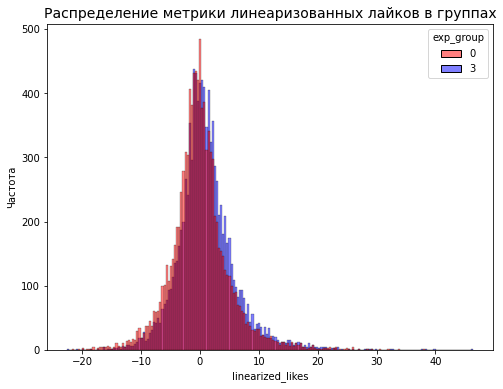

In [30]:
plt.figure(figsize=(8,6))
plt.title("Распределение метрики линеаризованных лайков в группах",size=14)
plt.ylabel("Частота",size=10)
groups = sns.histplot(data = pd.concat([group0, group3]), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

**Вывод:** Тест между группами 0 и 3 по новой метрике показал статистически значимое отличие. Как следствие, есть изменения и в пользовательских CTR. По графику и расчёту среднего можем говорить об увеличении CTR в группе 3 с новым алгоритмом рекомендации постов. 

### 3.2 Между группами 1 и 2 <a name="subparagraph322"></a>

**t-тест**  
**Нулевая гипотеза H₀:** средние значения линеаризованных лайков в 1 и 2 экспериментальных группах равны.  
**Альтернативная гипотеза H₁:** средние значения линеаризованных лайков в 1 и 2 экспериментальных группах не равны.

In [31]:
# t-тест по метрике линеаризованных лайков:
results_ttest(group1.linearized_likes, group2.linearized_likes, '1 и 2', 'Linearized_likes')

t-тест между группами 1 и 2 по метрике Linearized_likes
p-value: 9.439432187037644e-10
p_value < 0.05, т.е. средние измеряемой метрики в данных группах не равны


In [32]:
# t-тест по метрике ctr:
results_ttest(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, '1 и 2', 'CTR')

t-тест между группами 1 и 2 по метрике CTR
p-value: 0.4780623130874935
Не получилось отвергнуть нулевую гипотезу о равенстве средних


*p_value при анализировании новой метрики стал меньше.* 

*Результаты теста по первоначальной метрике CTR не позволили нам отвергнуть нулевую гипотезу о равенстве средних. Вероятнее всего, это связано с ассиметричностью данных.* 

*После улучшения оцениваемой метрики мы увидели, что  тест на новой метрике "прокрасился", а значит есть изменения и в исходном CTR.*

Посмотрим на средние новой метрики в данных группах и на гистограммы.

In [33]:
group1.linearized_likes.mean(), group2.linearized_likes.mean()

(-4.399034300171669e-16, -0.6592771236485204)

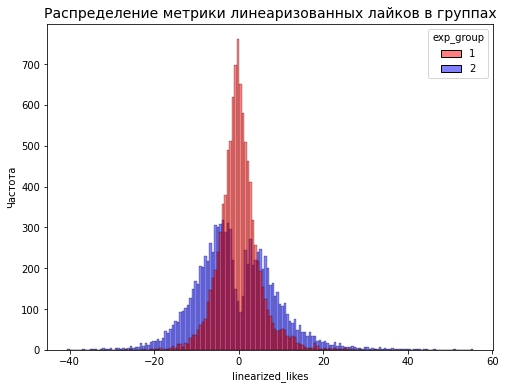

In [34]:
plt.figure(figsize=(8,6))
plt.title("Распределение метрики линеаризованных лайков в группах",size=14)
plt.ylabel("Частота",size=10)
groups = sns.histplot(data = pd.concat([group1, group2]), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

**Вывод:** Тест между группами 1 и 2 по новой метрике также показал, что есть статистически значимые различия по данной метрике между этими группами. И, соответственно, есть изменения и в пользовательских CTR. По графику и расчёту средних утверждать о видимом увеличении CTR в группе 2 с новым алгоритмом рекомендации постов нельзя. 

## 4. Вывод <a name="paragraph33"></a>

1. Тест между группами 0 и 3 по новой метрике показал статистически значимое отличие. Как следствие, есть изменения и в пользовательских CTR. По графику и расчёту среднего можем говорить об увеличении CTR в группе 3 с новым алгоритмом рекомендации постов.
2. Тест между группами 1 и 2 по новой метрике также показал, что есть статистически значимые различия в этой метрике между данными группами. И, соответственно, есть изменения и в пользовательских CTR. По графику и расчёту среднего утверждать о видимом увеличении CTR в группе 2 с новым алгоритмом рекомендации постов нельзя. 